<a href="https://colab.research.google.com/github/KerXiangTeh/Search-Algorithm-Exercise/blob/main/Python_Search_Algorithm_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reading Data File

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import numpy as np
from queue import PriorityQueue
from geopy.distance import geodesic as GD
from math import inf

In [17]:
path = "/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/"
df_cities = pd.read_csv(path + "cities.csv", header=None)
df_cities.rename(columns = {0: 'City', 1: 'Latitude', 2: 'Longitude'}, inplace = True)

In [18]:
df_distance = pd.read_csv(path + "distances.csv", header=None)
df_distance.rename(columns = {0: 'City From', 1: 'City To', 2: 'Distance'}, inplace=True) 

**Helper Functions**

In [19]:
def add_path_to_plot(plt, frm, to, cost):
  frm_lat = df_cities[df_cities['City'] == frm]['Latitude'].unique().tolist()
  frm_long = df_cities[df_cities['City'] == frm]['Longitude'].unique().tolist()
  to_lat = df_cities[df_cities['City'] == to]['Latitude'].unique().tolist()
  to_long = df_cities[df_cities['City'] == to]['Longitude'].unique().tolist()

  x=[]
  y=[]

  
  frm_long.extend(to_long)
  x = frm_long

  frm_lat.extend(to_lat)
  y = frm_lat

  #labeling points
  plt.annotate(frm, (x[0],y[0]), textcoords="offset points", xytext=(0,10), ha='center')
  plt.annotate(to, (x[1],y[1]), textcoords="offset points", xytext=(0,10), ha='center')

  #labeling edge
  edge_x = ((x[0] + x[1]) / 2)
  edge_y = ((y[0] + y[1]) / 2)
  plt.annotate(str(int(cost)), (edge_x, edge_y), textcoords="offset points", xytext=(0,10), ha='center')
  
  plt.plot(x,y)

In [20]:
def create_geo_dist_dict(df):
  dist_dict = {}
  for index, city in df_cities.iterrows():
    dist_dict[city[0]] = (city[1], city[2])

  return dist_dict

In [21]:
def create_distance_heuristics(dictionary, dest):
  heuristics = {}

  for key in dictionary:
    heuristics[key] = GD(dictionary[key], dictionary[dest]).mi
  
  return heuristics

Mapping routes between Texas cities

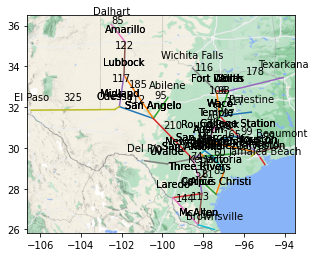

<Figure size 36000x36000 with 0 Axes>

In [22]:
img = plt.imread(path + 'texas-map.png')
fig, ax = plt.subplots()
ax.imshow(img, extent = [-106.64472275908936, -93.50995584876178, 25.8369213188412, 36.498771274119484])

for index, row in df_distance.iterrows():
  frm = row[0]
  to = row[1]
  cost = row[2]

  add_path_to_plot(plt, frm, to, cost)

plt.figure(figsize=(500,500))

plt.show()

##Creating datastructure we'll be using

In [23]:
class Vertex:
  def __init__(self, node):
    self.id = node
    self.adjacent = {}

  def __str__(self):
    return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])
  
  def add_neighbor(self, neighbor, weight=0):
    self.adjacent[neighbor] = weight
  
  def get_connections(self):
    return self.adjacent.keys()

  def get_id(self):
    return self.id

  def get_weight(self, neighbor):
    return self.adjacent[neighbor]

In [24]:

class Graph:
  def __init__(self):
    self.vert_dict = {}
    self.num_vertices = 0

  def __iter__(self):
    return iter(self.vert_dict.values())

  def add_vertex(self, node):
    self.num_vertices += 1
    new_vertex = Vertex(node)
    self.vert_dict[node] = new_vertex
    return new_vertex
  
  def get_vertex(self, node):
    if node in self.vert_dict:
      return self.vert_dict[node]
    else:
      return None
    
  def add_edge(self, frm, to, weight):
    if frm not in self.vert_dict:
      self.add_vertex(frm)
    if to not in self.vert_dict:
      self.add_vertex(to)
    
    self.vert_dict[frm].add_neighbor(self.vert_dict[to], weight)
    self.vert_dict[to].add_neighbor(self.vert_dict[frm], weight)

  def get_vertices(self):
    return self.vert_dict.keys()

  def bfs(self, start_node):
    frontier = []
    visited = {}
    solution = []
    total_cost = 0
    counter = 0
    if start_node not in self.vert_dict:
      return None
    else:
      frontier.append(start_node)
      visited[start_node] = True

      while frontier:
        start_node = frontier.pop(0)
        solution.append(start_node)

        for i in self.vert_dict[start_node].get_connections():
          vid = i.get_id()
          if vid not in visited or visited[vid] == False:
            frontier.append(vid)
            total_cost += self.vert_dict[start_node].get_weight(i)
            add_path_to_plot(plt, start_node, vid, self.vert_dict[start_node].get_weight(i))
            
            visited[vid] = True

      return solution, total_cost     

  def ucs(self, start_node):
    frontier = []
    visited = {}
    solution = []
    total_cost = 0
    if start_node not in self.vert_dict:
      return None
    else:
      heapq.heappush(frontier, (total_cost, start_node))
      visited[start_node] = True

      while frontier:
        tuple_item = heapq.heappop(frontier)
        curr_cost = tuple_item[0]
        start_node = tuple_item[1]
        solution.append(start_node)

        for i in self.vert_dict[start_node].get_connections():
          vid = i.get_id()
          if vid not in visited or visited[vid] == False:
            new_cost = curr_cost + self.vert_dict[start_node].get_weight(i)
            heapq.heappush(frontier, (new_cost, vid))
            total_cost += self.vert_dict[start_node].get_weight(i)
            add_path_to_plot(plt, start_node, vid, self.vert_dict[start_node].get_weight(i))
            visited[vid] = True
            
      return solution, total_cost

  def gbfs(self, start_node, goal_node):
    #Creating Heuristics
    city_coord_dict = create_geo_dist_dict(df_cities)
    heuristics = create_distance_heuristics(city_coord_dict, goal_node)
    
    frontier = []
    visited = {}
    solution = []
    total_cost = 0
    min_heuristic_cost = [start_node, heuristics[start_node]]
    min_node = None

    if start_node not in self.vert_dict:
      return None
    else:
      frontier.append(start_node)
      visited[start_node] = True

      while frontier:
        start_node = frontier.pop(0)
        solution.append(start_node)

        if (start_node == goal_node):
          return solution, total_cost

        min_heuristic_cost[1] = inf
        for i in self.vert_dict[start_node].get_connections():
          vid = i.get_id()
          if vid not in visited or visited[vid] == False:
            if (heuristics[vid] < min_heuristic_cost[1]):
              min_node = i
              min_heuristic_cost = [vid, heuristics[vid]]
              
        frontier.append(min_heuristic_cost[0])
        total_cost += self.vert_dict[start_node].get_weight(min_node)
        add_path_to_plot(plt, start_node, min_heuristic_cost[0], self.vert_dict[start_node].get_weight(min_node))
        visited[min_heuristic_cost[0]] = True

  def a_star(self, start_node, goal_node):
    #Creating Heuristics
    city_coord_dict = create_geo_dist_dict(df_cities)
    heuristics = create_distance_heuristics(city_coord_dict, goal_node)
    
    frontier = []
    visited = []
    total_cost = 0
    min_heuristic_cost = [start_node, heuristics[start_node]]
    min_node = None
    heuristic_cost = 0

    if start_node not in self.vert_dict:
      return None
    else:
      heuristic_cost = heuristics[start_node]
      heapq.heappush(frontier, (heuristic_cost, (total_cost, (start_node, [start_node]))))
      
      while frontier:
        tuple_item = heapq.heappop(frontier)
        heuristic_cost = tuple_item[0]
        curr_path_cost = tuple_item[1][0]
        start_node = tuple_item[1][1][0]
        solution = tuple_item[1][1][1]
        visited.append(start_node)
        
        if (start_node == goal_node):
          total_cost = curr_path_cost
          return solution, total_cost, visited

        for i in self.vert_dict[start_node].get_connections():
          vid = i.get_id()
          if (True):
            new_heuristic_cost = curr_path_cost + self.vert_dict[start_node].get_weight(i) + heuristics[vid]
            new_path_cost = curr_path_cost + self.vert_dict[start_node].get_weight(i)
            new_solution = solution + [vid]
            heapq.heappush(frontier, (new_heuristic_cost, (new_path_cost, (vid, new_solution))))
            

In [25]:
g_city = Graph()

sum = 0

for index, city in df_cities.iterrows():
  g_city.add_vertex(city[0])

for index, row in df_distance.iterrows():
  sum += row[2]
  g_city.add_edge(row[0], row[1], row[2])

In [26]:
def plot (solution):
  from_list = []
  dest_list = []

  for i in range(len(solution) - 1):
    from_list.append(solution[i])

  for i in range(1, len(solution)):
    dest_list.append(solution[i])

  for i in range(len(from_list)):
    edge_label = i + 1
    add_path_to_plot(plt, from_list[i], dest_list[i], edge_label)  

  plt.figure(figsize=(500,500))

  plt.show()

#Uninformed Search Agents

In this section, I will use the graph created in the previous section and write code for 2 uninformed search agents, Breadth First Search and Uniform Cost Search. The goal is to start from San Antonio and visit all the major cities in Texas. The output will be the following:

* The total distance traveled
* The path/sequence of citites expanded

BFS

Breadth First Search
Total Distance Travelled = 3325.5703758199998
Path:
0. San Antonio
1. San Angelo
2. New Braunfels
3. Seguin
4. Three Rivers
5. Uvalde
6. Midland
7. Lubbock
8. Abilene
9. San Marcos
10. Gonzalez
11. Columbus
12. Corpus Christi
13. Alice
14. Kenedy
15. Del Rio
16. Odessa
17. Amarillo
18. Austin
19. Victoria
20. Houston
21. Laredo
22. McAllen
23. El Paso
24. Dalhart
25. Round Rock
26. College Station
27. Beaumont
28. Galveston
29. Sugar Land
30. Brownsville
31. Temple
32. Waco
33. Jamaica Beach
34. Palestine
35. Fort Worth
36. Dallas
37. Wichita Falls
38. Texarkana


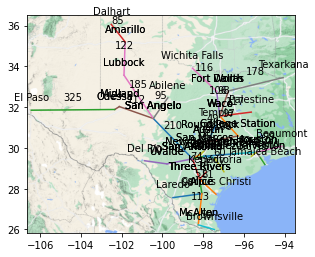

In [27]:
path = "/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/"
img = plt.imread(path + 'texas-map.png')
fig, ax = plt.subplots()
ax.imshow(img, extent = [-106.64472275908936, -93.50995584876178, 25.8369213188412, 36.498771274119484])

path, cost = g_city.bfs('San Antonio')



print("Breadth First Search")
print('Total Distance Travelled = ' + str(cost))
print('Path:')
for i in range(len(path)):
  print(str(i) + '. ' + str(path[i]))



UCS

Uniform Cost Search
Total Distance Travelled = 3357.0775630299995
Path:
0. San Antonio
1. New Braunfels
2. Seguin
3. San Marcos
4. Gonzalez
5. Three Rivers
6. Austin
7. Uvalde
8. Round Rock
9. Kenedy
10. Columbus
11. Alice
12. Victoria
13. Temple
14. Del Rio
15. Corpus Christi
16. Waco
17. College Station
18. San Angelo
19. Laredo
20. McAllen
21. Houston
22. Dallas
23. Fort Worth
24. Brownsville
25. Palestine
26. Sugar Land
27. Abilene
28. Galveston
29. Midland
30. Jamaica Beach
31. Beaumont
32. Odessa
33. Lubbock
34. Wichita Falls
35. Texarkana
36. Amarillo
37. Dalhart
38. El Paso


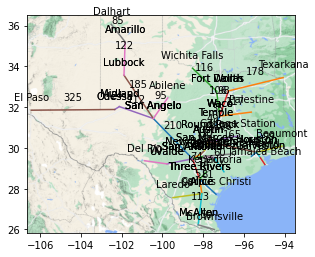

In [28]:
path = "/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/"
img = plt.imread(path + 'texas-map.png')
fig, ax = plt.subplots()
ax.imshow(img, extent = [-106.64472275908936, -93.50995584876178, 25.8369213188412, 36.498771274119484])

print("Uniform Cost Search")
path, cost = g_city.ucs('San Antonio')
print('Total Distance Travelled = ' + str(cost))
print('Path:')
for i in range(len(path)):
  print(str(i) + '. ' + str(path[i]))


#Informed Search Agents

In this section, I will use the graph created in the previous section and write code for 2 informed search agents, Greedy Best First Search and A* Search. My goal is to start from San Antonio and reach College Station in the fastest way possible. Output will be the following: 

* Total distance travelled
* The path/sequence of cities expanded

Greedy Best First Search

Greedy Best First Search
Visited - 
	San Antonio
	Seguin
	Columbus
	Houston
	College Station
Total Distance Travelled = 295.32038401
Path:
0. San Antonio
1. Seguin
2. Columbus
3. Houston
4. College Station


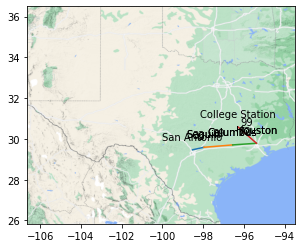

In [29]:
path = "/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/"
img = plt.imread(path + 'texas-map.png')
fig, ax = plt.subplots()
ax.imshow(img, extent = [-106.64472275908936, -93.50995584876178, 25.8369213188412, 36.498771274119484])

print("Greedy Best First Search")
path, cost = g_city.gbfs("San Antonio", "College Station")
print('Visited - ')
for i in range(len(path)):
  print('\t' + str(path[i]))

print('Total Distance Travelled = ' + str(cost))
print('Path:')
for i in range(len(path)):
  print(str(i) + '. ' + str(path[i]))


A-Star Search

A* Search
Visited - 
	San Antonio
	Seguin
	New Braunfels
	San Marcos
	Seguin
	Gonzalez
	Austin
	New Braunfels
	San Marcos
	Round Rock
	Gonzalez
	Seguin
	Columbus
	New Braunfels
	College Station
Total Distance Travelled = 186.77450141
Path:
0. San Antonio
1. New Braunfels
2. San Marcos
3. Austin
4. College Station


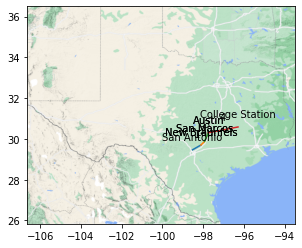

<Figure size 36000x36000 with 0 Axes>

In [30]:
path = "/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Data/"
img = plt.imread(path + 'texas-map.png')
fig, ax = plt.subplots()
ax.imshow(img, extent = [-106.64472275908936, -93.50995584876178, 25.8369213188412, 36.498771274119484])

print("A* Search")
path, cost, visited = g_city.a_star("San Antonio", "College Station")
print('Visited - ')
for i in range(len(visited)):
  print('\t' + str(visited[i]))
print('Total Distance Travelled = ' + str(cost))
print('Path:')
for i in range(len(path)):
  print(str(i) + '. ' + str(path[i]))

plot(path)
